<a href="https://colab.research.google.com/github/dkosinov/JS1/blob/master/planets_2022_10_31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Программа

In [1]:
from sqlite3 import Timestamp
import numpy as np
import pandas as pd
import json
import copy
# from datetime import datetime as dt
import time


def uniqueNumber():
    return int(time.time())

In [2]:
#################################################################################
#
#                           Расчёт и вывод результатов в Excel
#

# from operator import index


def getUniverseProfitRows(plnts, excel_file = False):

    total_G = getProfit(plnts, 'game')
    total_Ps = getProfit(plnts, 'players')

    # print(total_G.index)
    # print(total_Ps.index)

    # total = pd.concat([total_G.cumsum(), total_Ps.cumsum()], axis=1).fillna(0)
    # total = pd.concat([total_G, total_Ps], axis=1).fillna(0)
    total = total_Ps.join(total_G, lsuffix='_Players', rsuffix='_Game').fillna(0)

    # print(total.index)


    if excel_file:
        total.to_excel(f"data/planets_cash-flow_{uniqueNumber()}.xlsx")

    return total


def getProfit(plnts, gOps):
    
    i = 0

    plnts_df = None

    for pl in plnts:
        
        index, data = getData(pl, gOps)

        pl_df = pd.DataFrame(data=data, index=index, columns=[f"Planet {pl['planet_number']}"])
        
        plnts_df = pd.concat([plnts_df, pl_df], axis=1)

       
    res_df = addTotalColumn(plnts_df, gOps)


    return res_df    


def getData(pl, gOps):
    if gOps == 'game':
        indx = [pl['born_month']]
        data = [pl['game_profit']]
        
    elif gOps == 'players':
        indx = [m[0] for m in pl['units_cashflow']]
        data = [m[2] for m in pl['units_cashflow']]
    
    return indx, data


def addTotalColumn(dfs, gOps):
    # Добавляем итоговый столбец
    dfs = dfs.fillna(0)
    total = pd.DataFrame(dfs.sum(axis=1), columns = [f'Total_profit'])
    dfs = pd.concat([dfs, total], axis=1)

    return dfs

def getResData(plnts, excel_file = False):
    
    plnts_df = None

    for p in plnts:
        index = []
        data = []

        for prop in p:
            
            if prop != 'units_cashflow':
                index.append(prop)
                data.append(p[prop])

        # print(data, columns)
        pl_df = pd.DataFrame(data=data, index=index, columns=[f"Planet {p['planet_number']}"])
        
        plnts_df = pd.concat([plnts_df, pl_df], axis=1)

    # total = pd.DataFrame(plnts_df.sum(axis=1), index=['Total'])

    # plnts_df = plnts_df.append(total)
    
    if excel_file:   
        plnts_df.T.to_excel(f"data/planets_data_{uniqueNumber()}.xlsx")

    return plnts_df
            

In [3]:
#################################################################################
# 
#                     Загружаем итоги расчёта планет на графики


def getPlot(uni, cum = False, n = 0, months = 0, excel_file=False, show_plot = 1):
    """
    Выводим результаты планет на график

    uni             - вселенная с планетами
    cum = False     - нарастающий итого рядов
    n = 0           - количество отображаемых планет
    months = 0      - количество отображаемых месяцев
    """

    import matplotlib.pyplot as plt  
  
    if n > 0:
      planets = uni[:n]
      plot_name = f"{n} planets"
    else:
      planets = uni[:]
      plot_name = f"All planets"
    
    df = getUniverseProfitRows(planets, excel_file)

    plot = plt
    
    if months > 0:
      data = df[:months]
      plot_name = f"{plot_name}, {months} months"
    else:
      data = df[:]
      plot_name = f"{plot_name}, the all epochs"
    
    if show_plot:

        x  = data.index
        
        if cum:
            y1 = data['Total_profit_Game'].cumsum().values
            y2 = data['Total_profit_Players'].cumsum().values
        else:
            y1 = data['Total_profit_Game'].values
            y2 = data['Total_profit_Players'].values

        plot.plot(x, y1, label="Game")
        plot.plot(x, y2, label="Players")
        plot.plot()
        plot.xlabel("Periods")
        if cum:
          plot.ylabel("Profit Cum Sum")
        else:  
          plot.ylabel("Profit Sum")
        plot.title(plot_name)
        plot.legend()
        plot.show()

    return data


def getReport(uni, cum=False, n=0, months=0, excel_file=False, show_plot = False):
    
    if n > 0:
      planets = uni[:n]
    else:
      planets = uni[:]

    res = getResData(planets, excel_file)
    
    # print(res)

    rows = getPlot(uni, cum, n , months, excel_file, show_plot)

    return res, rows

In [4]:
#################################################################################
#
#                                   Расчёты для планеты

def getPlanet(discount_rate, plnt):
    """
    Заселение планеты юнитами
    функция рассчитывает результаты и временные ряды для юнитов    
    """
    planet_number = int(plnt[0])
    born_month =    int(plnt[1])
    ref_percent =   float(plnt[2])
    planet_tokens = float(plnt[3])
    opt_days =      int(plnt[4])
    d_percent =     float(plnt[5])
    min_percent =   float(plnt[6])
    units =         int(plnt[7])
    unit_price =    float(plnt[8])

    dr = discount_rate
    npv_units_profit = 0

    # min_percent = min_percent
    # units = units


    total_profit = tokens = planet_tokens * (1 - ref_percent/100)

    # print(total_profit, units * unit_price * (1 - ref_percent/100))
    # assert total_profit >= (units * unit_price * (1 - ref_percent/100))

    units_price = unit_price * units
    
    delta = ((2 * (100 / opt_days)) - (2 * d_percent)) / (opt_days - 1)
    
    day_percent = d_percent
    month_percent = d_percent
    months = []
    d = 1
    m = born_month - 1
    stop_payout = False
    stop_month_percent_min = False
    while (not stop_payout) and (not stop_month_percent_min):
        if (d % 30) == 0:
            m += 1
            if month_percent < min_percent:
                month_percent = min_percent
                stop_month_percent_min = True
            payout = units_price * month_percent/100
            if payout >= tokens:
                payout = tokens
                tokens = 0
                month_percent = payout / units_price * 100
                stop_payout = True
            else:
                tokens -= payout
            payout_cum = total_profit - tokens
            npv_m = payout * 1 / (1 + dr)**m
            npv_units_profit += npv_m
            months.append([m, month_percent, payout, payout_cum, tokens, npv_m])
            month_percent = 0
        if (not stop_payout) and (not stop_month_percent_min):
            day_percent += delta
            month_percent += day_percent
            # month_percent += delta
            d += 1
            
    if not stop_payout:
        month_percent = min_percent
        while not stop_payout:
            payout = units_price * month_percent/100
            if payout >= tokens:
                payout = tokens
                tokens = 0
                month_percent = payout / units_price * 100
                stop_payout = True
            else:
                tokens -= payout
            m += 1
            payout_cum = total_profit - tokens
            npv_m = payout * 1 / (1 + dr)**m
            npv_units_profit += npv_m
            months.append([m, month_percent, payout, payout_cum, tokens, npv_m])
    
    # подсчитываем итоги
    
    plato = 0
    befor_plato_percent = 0
    plato_percent = 0

    for mon in months:
        if mon[1] == min_percent:
            plato += 1
            plato_percent += mon[1]
        else: 
            befor_plato_percent += mon[1]
        
    # game_profit = units_price * (1 - ref_percent/100)
    game_profit = units_price
    game_profit_percent = game_profit/planet_tokens * 100

    nvp_game_profit = game_profit * 1/(1 + dr)**born_month
    npv_invest_units = units_price * 1/(1 + dr)**born_month
    npv_invest_unit = npv_invest_units / units
    roi_units = (npv_units_profit - npv_invest_units) / npv_invest_units * 100
    roi_unit = (npv_units_profit/units - npv_invest_unit) / npv_invest_unit * 100

    planet_res = {
        "planet_number" : int(planet_number),                                    # номер планеты
        "born_month" : int(born_month),                                          # месяц заселения планеты       
        "ref_%": ref_percent,                                         # процент реферальной программы
        "planet_tokens" : planet_tokens,                                    # токенов на всей планете
        "opt_days" : opt_days,                                              # скорость окупаемости
        "day_%" : d_percent,                                            # процент дохода в день
        "units" : units,                                                    # количество юнитов
        "unit_price" : unit_price,                                          # цена юнита
        "units_price" : units_price,                                          # цена юнита
        "fix_%" : round(min_percent, 2),                                       # ценность персонажа = минимальный фиксированный процент выплаты
        "game_profit": round(game_profit, 2),                                        # доход игры
        "game_profit_%": round(game_profit_percent, 2),                        # процент доходности игры
        "npv_game_profit" : round(nvp_game_profit, 2),                                             # чистая приведённая стоимость дохода игры
        "months_total" : months[-1][0],                                     # общий срок дистанции
        "months_profit" : months[-1][0] - plato,                            # общий срок дистанции до достижения минимального процента выплаты
        "months_plato" : plato,                                             # общий срок дистанции после достижения минимального процента выплаты
        "units_profit_%" : round(total_profit / units_price * 100, 2),        # процент дохода игроков
        "befor_plato_%" : round(befor_plato_percent, 2),                       # процент дохода до выхода на мин процент
        "plato_%" : round(plato_percent, 2),                                    # процент дохода после выхода на мин процент
        "units_profit" : round(total_profit, 2),                                     # общая сумма дохода всех токенов
        "npv_invest_units" : round(npv_invest_units, 2),                              # чистая приведённая стоимость инвестиций игроков
        "npv_units_profit" : round(npv_units_profit, 2),                                            # чистая приведённая стоимость выплат игрокам
        "roi_units_%" : round(roi_units, 2),                                            # roi игроков
        "unit_profit" : round(total_profit / units, 2),                               # общая сумма дохода игрока
        "npv_invest_unit" : round(npv_invest_units,2),                               # чистая приведённая стоимость инвестиций в юнит
        "npv_unit_profit" : round(npv_units_profit / units, 2),                                    # чистая приведённая стоимость выплат юнита
        "roi_unit_%" : round(roi_unit, 2),                                             # roi юнита
        "units_cashflow" : months,                                          # временной ряд с cash flow юнита
    }
    
    return planet_res


In [5]:
#################################################################################
# 
#                                   Создание Вселенной
    
def genesisUniverse(
    discount_rate, 
    plnts_to_born,
    plnts_data,
    tkns_max
):
    tkns = 0
    for pl in plnts_data:
        tkns += pl[3]
    
    print(tkns_max, tkns )
    assert tkns_max == tkns 

    planets = []

    for born, planet in zip(plnts_to_born, plnts_data):
        
        if born:
            planets.append(getPlanet(discount_rate, planet))


    return planets


In [6]:

def main(discount_rate, plnts_data, plnts_to_born, tkns_max):
    universe = genesisUniverse(
        discount_rate = discount_rate, 
        plnts_data = plnts_data,

        plnts_to_born = plnts_to_born,
        tkns_max = tkns_max
    )
    return universe

# Игра 1

In [7]:
# Игра 1

discount_rate = 10 / 100

tkns_max = 60 * 10**6

plnts_data = [

            # параметры
        
            #   №   наименование                вариативность параметра             влияние на результат юнита
            #   1   planet_number               
            #   2   born_month                                                                       
            #   3   ref_%                       10                  = 1             уменьшает майнинг пул/ доходность юнитов, можно установить разный процент для каждой планеты
            #   4   planet_tokens               2 000 000           = 1
            #   5   opt_days                    90, 120, 180        = 3             стартовая мощность насоса, уменьшение резко снижает выработку и увеличивает срок окупаемости,  
            #   6   day_%                       1.12, 1.14, 1.16    = 3             износостойкость насоса, уменьшение приводить к более быстрому подению выработки и увеличивает срок окупаемости, 
            #   7   fix_%                       7, 5, 3             = 3             остаточная мощность насоса, уменьшение снижает остаточный фиксированный % выработки и увеличивает срок окупаемости,  
            #   8   units                       10 000              = 1
            #   9   unit_price                  10                  = 1

            #   1 * 1 * 3 * 3 * 3 * 1 * 1 * 27 стратегий

            # Комбинация параметров 4, 8, 9 влияет на доходность игры и игроков. Чем больше значения соотношения (8 * 9) / 4, тем меньше % доходности игры и больше игрока
            # Значение параметра 9 влияет на стоимсоть участия, чем выше, тем выше цена за вход
            #  

            #   1    2     3     4              5      6       7    8            9       #    Номер стратегии
            #------------------------------------------------------------------------------------------------
            [   1,   1,    10,   2 * (10**6),   90,    1.12,   7,   1 * 10**4,   10  ],  #    1   
            [   2,   1,    10,   2 * (10**6),   90,    1.12,   7,   1 * 10**4,   10  ],  #    1   
            [   3,   1,    10,   2 * (10**6),   90,    1.12,   7,   1 * 10**4,   10  ],  #    1   

            [   4,   2,    10,   2 * (10**6),   90,    1.12,   7,   1 * 10**4,   10  ],  #    1
            [   5,   3,    10,   2 * (10**6),   90,    1.12,   5,   1 * 10**4,   10  ],  #    2     
            [   6,   4,    10,   2 * (10**6),   90,    1.12,   3,   1 * 10**4,   10  ],  #    3     
            [   7,   5,    10,   2 * (10**6),   90,    1.14,   7,   1 * 10**4,   10  ],  #    4     
            [   8,   6,    10,   2 * (10**6),   90,    1.14,   5,   1 * 10**4,   10  ],  #    5     
            [   9,   7,    10,   2 * (10**6),   90,    1.14,   3,   1 * 10**4,   10  ],  #    6
            [  10,   8,    10,   2 * (10**6),   90,    1.16,   7,   1 * 10**4,   10  ],  #    7
            [  11,   9,    10,   2 * (10**6),   90,    1.16,   5,   1 * 10**4,   10  ],  #    8
            [  12,   10,   10,   2 * (10**6),   90,    1.16,   3,   1 * 10**4,   10  ],  #    9

            [  13,   11,   10,   2 * (10**6),   120,   1.12,   7,   1 * 10**4,   10  ],  #    10
            [  14,   12,   10,   2 * (10**6),   120,   1.12,   5,   1 * 10**4,   10  ],  #    11
            [  15,   13,   10,   2 * (10**6),   120,   1.12,   3,   1 * 10**4,   10  ],  #    12
            [  16,   15,   10,   2 * (10**6),   120,   1.14,   7,   1 * 10**4,   10  ],  #    13
            [  17,   17,   10,   2 * (10**6),   120,   1.14,   5,   1 * 10**4,   10  ],  #    14
            [  18,   19,   10,   2 * (10**6),   120,   1.14,   3,   1 * 10**4,   10  ],  #    15
            [  19,   21,   10,   2 * (10**6),   120,   1.16,   7,   1 * 10**4,   10  ],  #    16
            [  20,   23,   10,   2 * (10**6),   120,   1.16,   5,   1 * 10**4,   10  ],  #    17
            [  21,   25,   10,   2 * (10**6),   120,   1.16,   3,   1 * 10**4,   10  ],  #    18

            [  22,   28,   10,   2 * (10**6),   180,   1.12,   7,   1 * 10**4,   10  ],  #    19
            [  23,   31,   10,   2 * (10**6),   180,   1.12,   5,   1 * 10**4,   10  ],  #    20
            [  24,   34,   10,   2 * (10**6),   180,   1.12,   3,   1 * 10**4,   10  ],  #    21
            [  25,   37,   10,   2 * (10**6),   180,   1.14,   7,   1 * 10**4,   10  ],  #    22
            [  26,   41,   10,   2 * (10**6),   180,   1.14,   5,   1 * 10**4,   10  ],  #    23
            [  27,   45,   10,   2 * (10**6),   180,   1.14,   3,   1 * 10**4,   10  ],  #    24
            [  28,   49,   10,   2 * (10**6),   180,   1.16,   7,   1 * 10**4,   10  ],  #    25
            [  29,   55,   10,   2 * (10**6),   180,   1.16,   5,   1 * 10**4,   10  ],  #    26
            [  30,   61,   10,   2 * (10**6),   180,   1.16,   3,   1 * 10**4,   10  ],  #    27
        ]

plnts_to_born = [
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            # 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        ]

universe = main(discount_rate, plnts_data, plnts_to_born, tkns_max)
print(f"Planets: {len(universe)}")

60000000 60000000
Planets: 30


# Результат для игры и игроков первых N месяцев

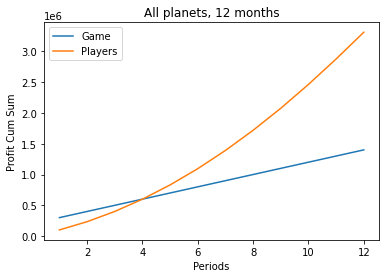

Total_profit_Game       1400000.00
Total_profit_Players    3309951.75
dtype: float64


,Total_profit_Game,Total_profit_Players
1,300000.0,100539.33
2,400000.0,234052.44
3,500000.0,400359.56
4,600000.0,599280.91
5,700000.0,831041.21
6,800000.0,1095056.19
7,900000.0,1390741.58
8,1000000.0,1717917.61
9,1100000.0,2075595.51
10,1200000.0,2462786.52


In [15]:
# Результат для игры и игроков первых N месяцев
N = 12
res, rows = getReport(uni=universe, cum=1, n=0, months=N, excel_file = 0, show_plot = 1)
print(rows.filter(items=['Total_profit_Game','Total_profit_Players']).sum().round(2))
rows.filter(items=['Total_profit_Game','Total_profit_Players']).round(2).cumsum()

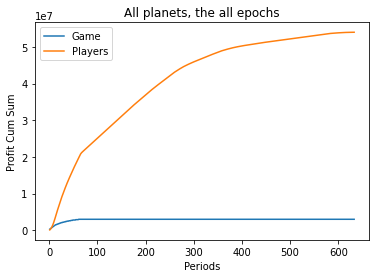

Total_profit_Game        3000000.0
Total_profit_Players    54000000.0
dtype: float64


In [10]:
# результаты за весь период
res, rows = getReport(uni=universe, cum=1, n=0, months=0, excel_file = 0, show_plot = 1)
print(rows.filter(items=['Total_profit_Game','Total_profit_Players']).sum().round(2))

#Результаты для Игры

In [11]:
print('Результаты для игры')
res.T.filter(items=['ref_%',
                    'born_month',
                    'game_profit', 
                    'game_profit_%',
                    'npv_game_profit',
                    'fix_%',
                    'planet_tokens',
                    'opt_days',
                    'day_%',
                    'unit_price',
                    'months_total',
                    'months_profit',
                    'months_plato'
                ]
).round(2)

Результаты для игры


,ref_%,born_month,game_profit,game_profit_%,npv_game_profit,fix_%,planet_tokens,opt_days,day_%,unit_price,months_total,months_profit,months_plato
Planet 1,10.0,1.0,100000.0,5.0,90909.09,7.0,2000000.0,90.0,1.12,10.0,65.0,65.0,0.0
Planet 2,10.0,1.0,100000.0,5.0,90909.09,7.0,2000000.0,90.0,1.12,10.0,65.0,65.0,0.0
Planet 3,10.0,1.0,100000.0,5.0,90909.09,7.0,2000000.0,90.0,1.12,10.0,65.0,65.0,0.0
Planet 4,10.0,2.0,100000.0,5.0,82644.63,7.0,2000000.0,90.0,1.12,10.0,66.0,66.0,0.0
Planet 5,10.0,3.0,100000.0,5.0,75131.48,5.0,2000000.0,90.0,1.12,10.0,67.0,67.0,0.0
Planet 6,10.0,4.0,100000.0,5.0,68301.35,3.0,2000000.0,90.0,1.12,10.0,68.0,68.0,0.0
Planet 7,10.0,5.0,100000.0,5.0,62092.13,7.0,2000000.0,90.0,1.14,10.0,171.0,52.0,119.0
Planet 8,10.0,6.0,100000.0,5.0,56447.39,5.0,2000000.0,90.0,1.14,10.0,219.0,56.0,163.0
Planet 9,10.0,7.0,100000.0,5.0,51315.81,3.0,2000000.0,90.0,1.14,10.0,329.0,60.0,269.0
Planet 10,10.0,8.0,100000.0,5.0,46650.74,7.0,2000000.0,90.0,1.16,10.0,209.0,36.0,173.0


#Результаты для всех игроков

In [12]:
print('Результаты для всех игроков')
res.T.filter(items=['born_month',
                    'opt_days',
                    "units_price",
                    "units_profit", 
                    "units_profit_%",
                    "befor_plato_%",
                    "plato_%",
                    "npv_invest_units", 
                    "npv_units_profit", 
                    "roi_units_%",
                    "months_total", 
                    "months_profit", 
                    "months_plato", 
                ]
).round(2)

Результаты для всех игроков


,born_month,opt_days,units_price,units_profit,units_profit_%,befor_plato_%,plato_%,npv_invest_units,npv_units_profit,roi_units_%,months_total,months_profit,months_plato
Planet 1,1.0,90.0,100000.0,1800000.0,1800.0,1800.0,0.0,90909.09,316736.08,248.41,65.0,65.0,0.0
Planet 2,1.0,90.0,100000.0,1800000.0,1800.0,1800.0,0.0,90909.09,316736.08,248.41,65.0,65.0,0.0
Planet 3,1.0,90.0,100000.0,1800000.0,1800.0,1800.0,0.0,90909.09,316736.08,248.41,65.0,65.0,0.0
Planet 4,2.0,90.0,100000.0,1800000.0,1800.0,1800.0,0.0,82644.63,287941.89,248.41,66.0,66.0,0.0
Planet 5,3.0,90.0,100000.0,1800000.0,1800.0,1800.0,0.0,75131.48,261765.36,248.41,67.0,67.0,0.0
Planet 6,4.0,90.0,100000.0,1800000.0,1800.0,1800.0,0.0,68301.35,237968.50,248.41,68.0,68.0,0.0
Planet 7,5.0,90.0,100000.0,1800000.0,1800.0,967.0,833.0,62092.13,192249.90,209.62,171.0,52.0,119.0
Planet 8,6.0,90.0,100000.0,1800000.0,1800.0,985.0,815.0,56447.39,174647.77,209.40,219.0,56.0,163.0
Planet 9,7.0,90.0,100000.0,1800000.0,1800.0,993.0,807.0,51315.81,158688.37,209.24,329.0,60.0,269.0
Planet 10,8.0,90.0,100000.0,1800000.0,1800.0,589.0,1211.0,46650.74,129035.10,176.60,209.0,36.0,173.0


#Результаты для юнита

In [13]:
print('Результаты юнита')
res.T.filter(items=['born_month',
                    'opt_days',
                    "unit_price",
                    "unit_profit", 
                    "units_profit_%",
                    "befor_plato_%",
                    "plato_%",
                    "npv_invest_unit", 
                    "npv_unit_profit", 
                    "roi_unit_%",
                    "months_total", 
                    "months_profit", 
                    "months_plato" 
                ]
).round(2)

Результаты юнита


,born_month,opt_days,unit_price,unit_profit,units_profit_%,befor_plato_%,plato_%,npv_invest_unit,npv_unit_profit,roi_unit_%,months_total,months_profit,months_plato
Planet 1,1.0,90.0,10.0,180.0,1800.0,1800.0,0.0,90909.09,31.67,248.41,65.0,65.0,0.0
Planet 2,1.0,90.0,10.0,180.0,1800.0,1800.0,0.0,90909.09,31.67,248.41,65.0,65.0,0.0
Planet 3,1.0,90.0,10.0,180.0,1800.0,1800.0,0.0,90909.09,31.67,248.41,65.0,65.0,0.0
Planet 4,2.0,90.0,10.0,180.0,1800.0,1800.0,0.0,82644.63,28.79,248.41,66.0,66.0,0.0
Planet 5,3.0,90.0,10.0,180.0,1800.0,1800.0,0.0,75131.48,26.18,248.41,67.0,67.0,0.0
Planet 6,4.0,90.0,10.0,180.0,1800.0,1800.0,0.0,68301.35,23.80,248.41,68.0,68.0,0.0
Planet 7,5.0,90.0,10.0,180.0,1800.0,967.0,833.0,62092.13,19.22,209.62,171.0,52.0,119.0
Planet 8,6.0,90.0,10.0,180.0,1800.0,985.0,815.0,56447.39,17.46,209.40,219.0,56.0,163.0
Planet 9,7.0,90.0,10.0,180.0,1800.0,993.0,807.0,51315.81,15.87,209.24,329.0,60.0,269.0
Planet 10,8.0,90.0,10.0,180.0,1800.0,589.0,1211.0,46650.74,12.90,176.60,209.0,36.0,173.0
